In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc, pickle

In [5]:
df_train_identity = pd.read_csv('data/ieee-fraud-detection/train_identity.csv')
df_train_transaction = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv')

df_test_identity = pd.read_csv('data/ieee-fraud-detection/test_identity.csv')
df_test_transaction = pd.read_csv('data/ieee-fraud-detection/test_transaction.csv')

In [ ]:
df_train_identity.info()

In [ ]:
df_train_identity.head(3)

In [ ]:
df_train_transaction.info()

In [ ]:
df_train_transaction.head(3)

In [6]:
df_train = pd.merge(df_train_transaction, df_train_identity, on=['TransactionID'], how='left')
df_test = pd.merge(df_test_transaction, df_test_identity, on=['TransactionID'], how='left')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [8]:
def fileter_numeric_cols(data):

    numeric_cols = set()
    numric_cols_cnt = 0

    for col in data.columns:
        col_type = str(data[col].dtypes)
        #print(col_type, type(col_type))
        if col_type[:3] == 'int' or col_type[:5] == 'float' or col_type[:6] == 'double':
            numeric_cols.add(col_type)
            numric_cols_cnt  += 1

    return list(numeric_cols), numric_cols_cnt, numric_cols_cnt/len(data.columns)

train_num_cols, train_numric_cols_cnt, train_numric_cols_rate = fileter_numeric_cols(df_train)

print("数字相关的列有{0}个，类型为{1}个，占比{2}\n{3}".format(train_numric_cols_cnt, len(train_num_cols), \
                                              train_numric_cols_rate, train_num_cols))

数字相关的列有403个，类型为2个，占比0.9285714285714286
['float64', 'int64']


In [11]:
df_train[['id_01', 'id_02']].describe()

,id_01,id_02
count,144233.000000,140872.000000
mean,-10.170502,174716.584708
std,14.347949,159651.816856
min,-100.000000,1.000000
25%,-10.000000,67992.000000
50%,-5.000000,125800.500000
75%,-5.000000,228749.000000
max,0.000000,999595.000000


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

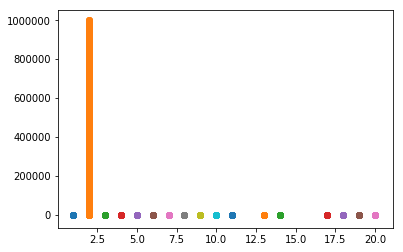

In [12]:
def plot_id_distribution(data, id_rg, new_rg):
    
    id_rg = min(id_rg, 38)
    
    for i in range(id_rg):
        cols = str(i+1) if i >= 9 else '0'+str(i+1)
        
        if str(df_train['id_%s' % cols].dtypes) == 'object':
            continue
        
        plt.scatter([i+1] * df_train.shape[0], df_train['id_%s' % cols])
        
        np_info = np.info(df_train['id_%s' % cols].dtypes)
        #print(df_train['id_%s' % cols].dtypes)
        #plt.scatter([i+1] * 2, [np_info.min(), np_info.max()])
    
    np_info = np.finfo(new_rg)
    plt.plot(list(range(id_rg)), [np_info.min]*id_rg, [np_info.max]*id_rg)
    
    
plot_id_distribution(df_train, 20, np.float16)

In [51]:
train_num_cols

['float64', 'int64']

In [9]:
def reduce_mem_usage(df, numerics, verbose=True):
    #numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, \
                                                                    100 * (start_mem - end_mem) / start_mem))
    return df

df_train = reduce_mem_usage(df_train, train_num_cols)
df_test = reduce_mem_usage(df_test, train_num_cols)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [10]:
del df_train_transaction, df_train_identity, df_test_transaction, df_test_identity

gc.collect()

35

In [11]:
with open('df_merged_train.pkl', 'wb') as f:
    pickle.dump(df_train, f)
    print("df_train dump finished")
    
with open('df_merged_test.pkl', 'wb') as f:
    pickle.dump(df_test, f)    
    print("df_test dump finished")

df_train dump finished
df_test dump finished


In [19]:
#后面无操作数据了
with open('df_merged_train.pkl', 'rb') as f:
    df_train = pickle.load(f)
    print("df_train load finished")
    
with open('df_merged_test.pkl', 'rb') as f:
    df_test = pickle.load(f)    
    print("df_test load finished")

df_train load finished
df_test load finished


In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [12]:
data_null = df_train.isnull().sum()
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)

data_null = data_null / df_train.shape[0] * 100

print("非空列有{0}个 空列占比{1}%".format(df_train.shape[1] - len(data_null), len(data_null) / df_train.shape[1] * 100))

非空列有20个 空列占比95.39170506912443%


null rate >= 75.0 的列有208个，占比总null列50.24155%


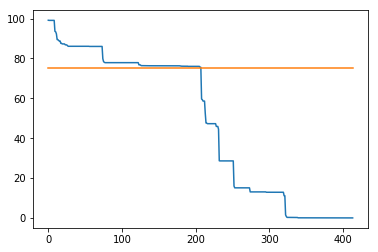

In [20]:
null_rate = 0.75 * 100

plt.plot(np.arange(data_null.shape[0]), data_null)
plt.plot(np.arange(data_null.shape[0]), np.array([null_rate] * data_null.shape[0]))

print("null rate >= {0} 的列有{1}个，占比总null列{2:.5f}%".format(null_rate, np.sum(data_null > null_rate), \
                                                     np.sum(data_null > null_rate) / data_null.shape[0]  * 100 ))

In [21]:
data_null

id_24    99.196159
id_25    99.130965
id_07    99.127070
id_08    99.127070
id_21    99.126393
id_26    99.125715
id_22    99.124699
id_23    99.124699
id_27    99.124699
dist2    93.628374
D7       93.409930
id_18    92.360721
D13      89.509263
D14      89.469469
D12      89.041047
id_04    88.768923
id_03    88.768923
D6       87.606767
id_33    87.589494
D9       87.312290
id_10    87.312290
D8       87.312290
id_09    87.312290
id_30    86.865411
id_32    86.861855
id_34    86.824771
id_14    86.445626
V155     86.123717
V141     86.123717
V142     86.123717
           ...    
V284      0.002032
V285      0.002032
V286      0.002032
V287      0.002032
V291      0.002032
V290      0.002032
V318      0.002032
V305      0.002032
V292      0.002032
V293      0.002032
V319      0.002032
V320      0.002032
V321      0.002032
V312      0.002032
V311      0.002032
V310      0.002032
V309      0.002032
V308      0.002032
V307      0.002032
V306      0.002032
V317      0.002032
V304      0.

In [22]:
data_null[data_null > null_rate].index

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2',
       ...
       'V250', 'V221', 'V251', 'V255', 'V272', 'V256', 'V259', 'V220', 'id_12',
       'id_01'],
      dtype='object', length=208)

In [23]:
df_train.shape, df_test.shape

((590540, 434), (506691, 433))

In [21]:
#null_rate = 0.75

df_train = df_train.drop(data_null[data_null > null_rate].index, axis=1)
df_test = df_test.drop(data_null[data_null > null_rate].index, axis=1)


In [22]:
df_train.shape, df_test.shape

((590540, 226), (506691, 225))

In [23]:
def fill_numbers(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():  # case if row has NA value, then return False, also inverse returns True.
                props[col].fillna(mn-1,inplace=True)  

    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

df_train = fill_numbers(df_train)
df_test = fill_numbers(df_test)

Memory usage of properties dataframe is : 324.95649337768555  MB
******************************
Column:  TransactionID
******************************
Column:  isFraud
******************************
Column:  TransactionDT
******************************
Column:  TransactionAmt
******************************
Column:  card1
******************************
Column:  card2
******************************
Column:  card3
******************************
Column:  card5
******************************
Column:  addr1
******************************
Column:  addr2
******************************
Column:  dist1
******************************
Column:  C1
******************************
Column:  C2
******************************
Column:  C3
******************************
Column:  C4
******************************
Column:  C5
******************************
Column:  C6
******************************
Column:  C7
******************************
Column:  C8
******************************
Column:  C9
***************

******************************
Column:  V293
******************************
Column:  V294
******************************
Column:  V295
******************************
Column:  V296
******************************
Column:  V297
******************************
Column:  V298
******************************
Column:  V299
******************************
Column:  V300
******************************
Column:  V301
******************************
Column:  V302
******************************
Column:  V303
******************************
Column:  V304
******************************
Column:  V305
******************************
Column:  V306
******************************
Column:  V307
******************************
Column:  V308
******************************
Column:  V309
******************************
Column:  V310
******************************
Column:  V311
******************************
Column:  V312
******************************
Column:  V313
******************************
Column:  V314
**********

******************************
Column:  V130
******************************
Column:  V131
******************************
Column:  V132
******************************
Column:  V133
******************************
Column:  V134
******************************
Column:  V135
******************************
Column:  V136
******************************
Column:  V137
******************************
Column:  V279
******************************
Column:  V280
******************************
Column:  V281
******************************
Column:  V282
******************************
Column:  V283
******************************
Column:  V284
******************************
Column:  V285
******************************
Column:  V286
******************************
Column:  V287
******************************
Column:  V288
******************************
Column:  V289
******************************
Column:  V290
******************************
Column:  V291
******************************
Column:  V292
**********

In [27]:
df_train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,99.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
data_null_1 = df_train.isnull().sum()
data_null_1 = data_null_1.drop(data_null_1[data_null_1 == 0].index).sort_values(ascending=False)

data_null_1 = data_null_1 / df_train.shape[0] * 100


In [25]:
data_null_1

M5               59.349409
M7               58.635317
M9               58.633115
M8               58.633115
M4               47.658753
M3               45.907136
M2               45.907136
M1               45.907136
M6               28.678836
P_emaildomain    15.994852
card4             0.267044
card6             0.266028
dtype: float64

In [30]:
#plt.bar(np.arange(df_train['M5'].value_counts(dropna=False).shape[0]), \
#            height=df_train['M5'].value_counts(dropna=False), width=0.3)
def visualize_cols(data, cols, sub_size=(1, 1), figsize=(40, 30)):
    fig = plt.figure(figsize=figsize)
    
    
    for idx, col in enumerate(cols):
        #col = 'M5'
        ax  = fig.add_subplot(sub_size[0], sub_size[1], idx+1)
        
        x_pos = np.arange(data[col].value_counts(dropna=False).shape[0])
        y_pos = data[col].value_counts(dropna=False)

        ax.bar(x=0, bottom=x_pos, height=0.3, width=y_pos, orientation="horizontal", \
                    label=col, tick_label=y_pos.index)
        
        ax.tick_params(labelsize=30) 
        
        for tick in ax.get_yticklabels(): 
            tick.set_rotation(30)
        for tick in ax.get_xticklabels():  
            tick.set_rotation(30)
        
        # 添加图例
        ax.legend(prop={'size':30})

    # 展示图形
    plt.show()
    
    

In [268]:
#是否可以做一个对col、isFraud双类别进行分组，并plot

def visualize_cols_tmp(data, cols, sub_size=(1, 1), figsize=(40, 30)):
    fig = plt.figure(figsize=figsize)
    
    
    for idx, col in enumerate(cols):
        #col = 'M5'
        ax  = fig.add_subplot(sub_size[0], sub_size[1], idx+1)
        
        fraud_cols_grp = df_train[['isFraud', col]].groupby('isFraud')
        print(fraud_cols_grp.size())
        
        x_pos = np.arange(data[col].value_counts(dropna=False).shape[0])
        mb = data[col].value_counts(dropna=False)
        
        y_pos = fraud_cols_grp.get_group(0)[col].value_counts(dropna=False, cols=mb.index)

        ax.bar(x=0, bottom=x_pos, height=0.3, width=y_pos, orientation="horizontal", \
                    label=col+" Fraud-0", tick_label=y_pos.index)
        
        #fraud == 1
        y_pos = fraud_cols_grp.get_group(1)[col].value_counts(dropna=False, cols=mb.index)
        print(y_pos)
        print(x_pos, y_pos.index)
        ax.bar(x=1, bottom=x_pos, height=0.3, width=y_pos+1, orientation="horizontal", \
                    label=col+" Fraud-1", tick_label=y_pos.index)
        
        ax.tick_params(labelsize=30) 
        
        for tick in ax.get_yticklabels(): 
            tick.set_rotation(30)
        for tick in ax.get_xticklabels():  
            tick.set_rotation(30)
        
        # 添加图例
        ax.legend(prop={'size':30})

    # 展示图形
    plt.show()
    
    

isFraud
0    569877
1     20663
dtype: int64


TypeError: value_counts() got an unexpected keyword argument 'cols'

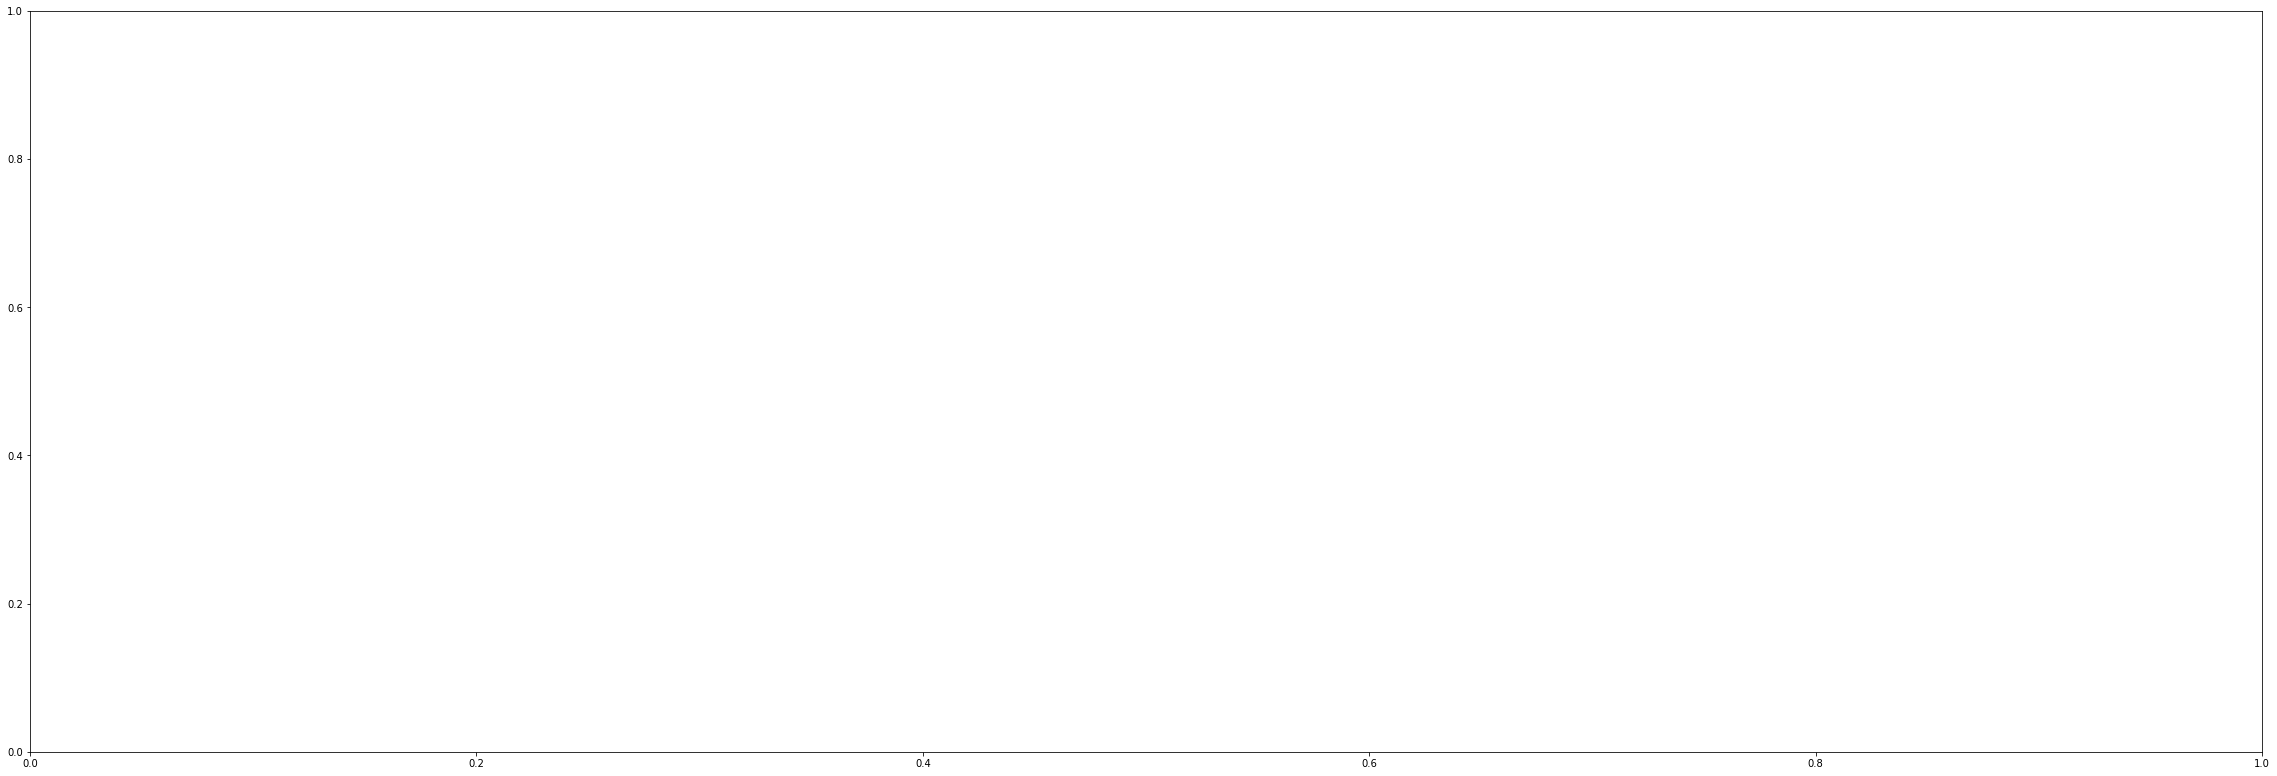

In [269]:
visualize_cols_tmp(df_train, ['card4', 'card6'], (2, 1))

In [31]:
tmp = df_train[['isFraud', 'M4']].groupby('isFraud')

In [32]:
tmp.get_group(0)['M4'].value_counts(dropna=False)

NaN    276217
M0     189207
M2      53056
M1      51397
Name: M4, dtype: int64

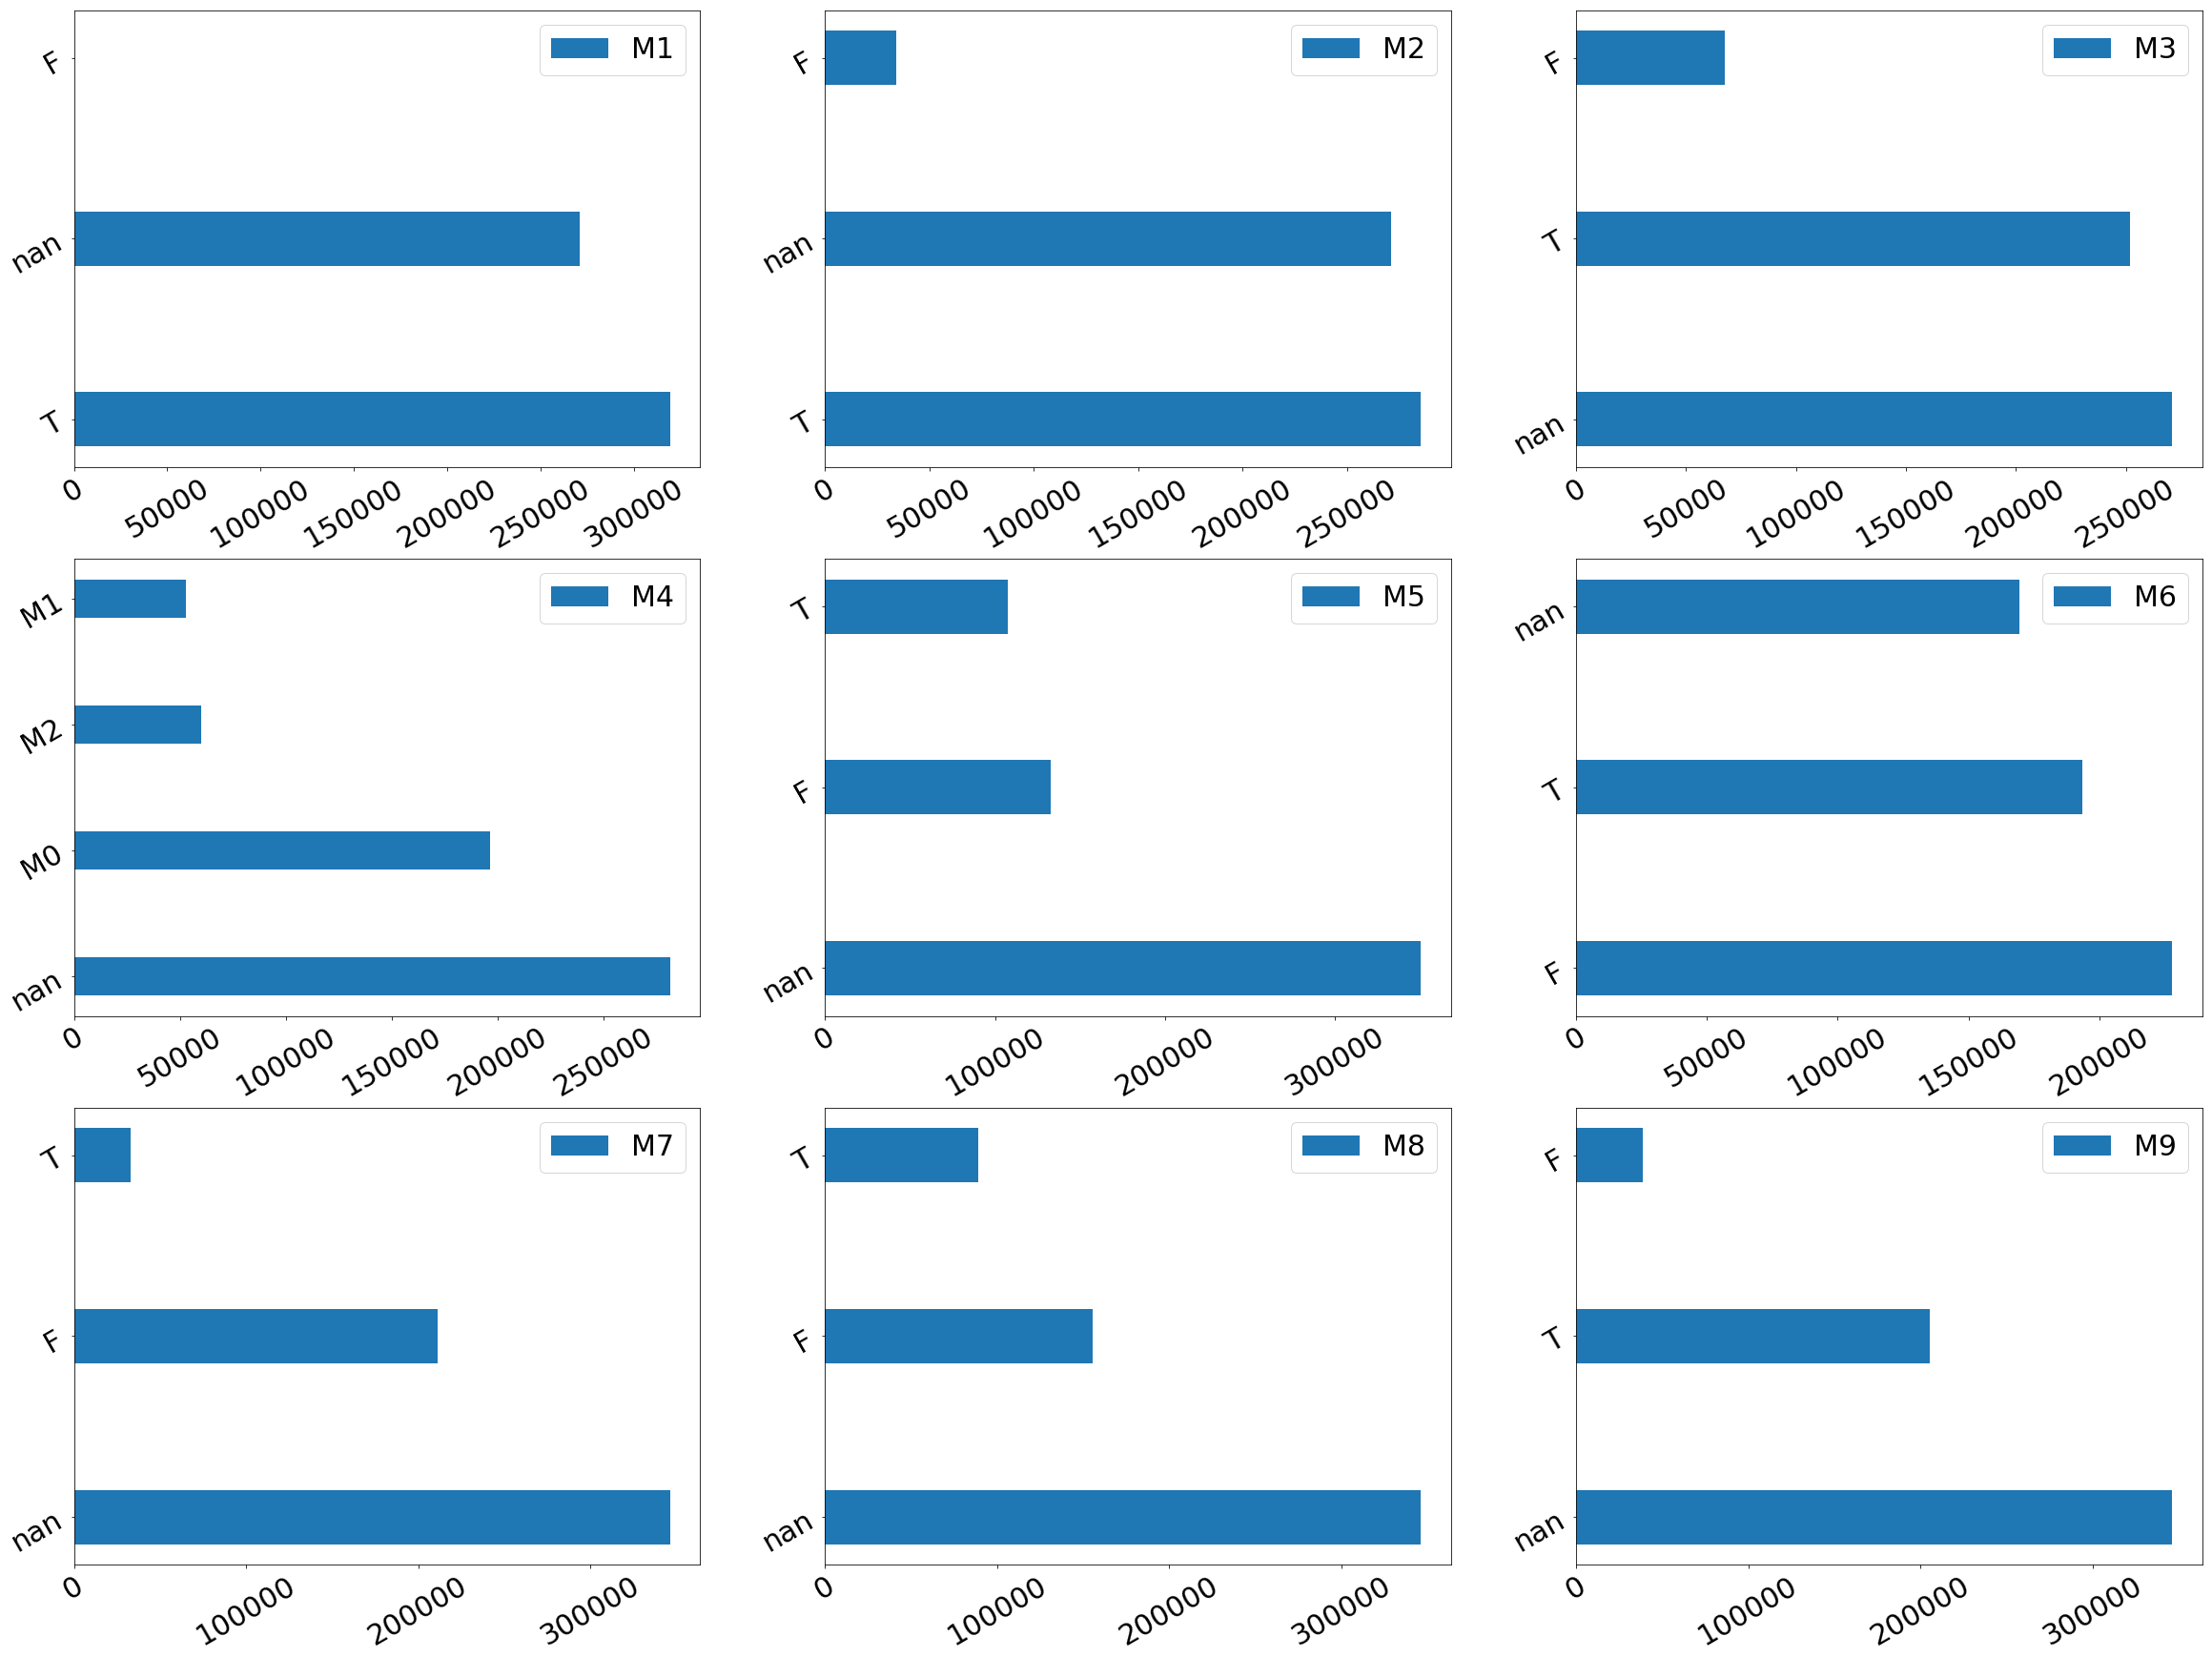

In [33]:
visualize_cols(df_train, ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], (3, 3))

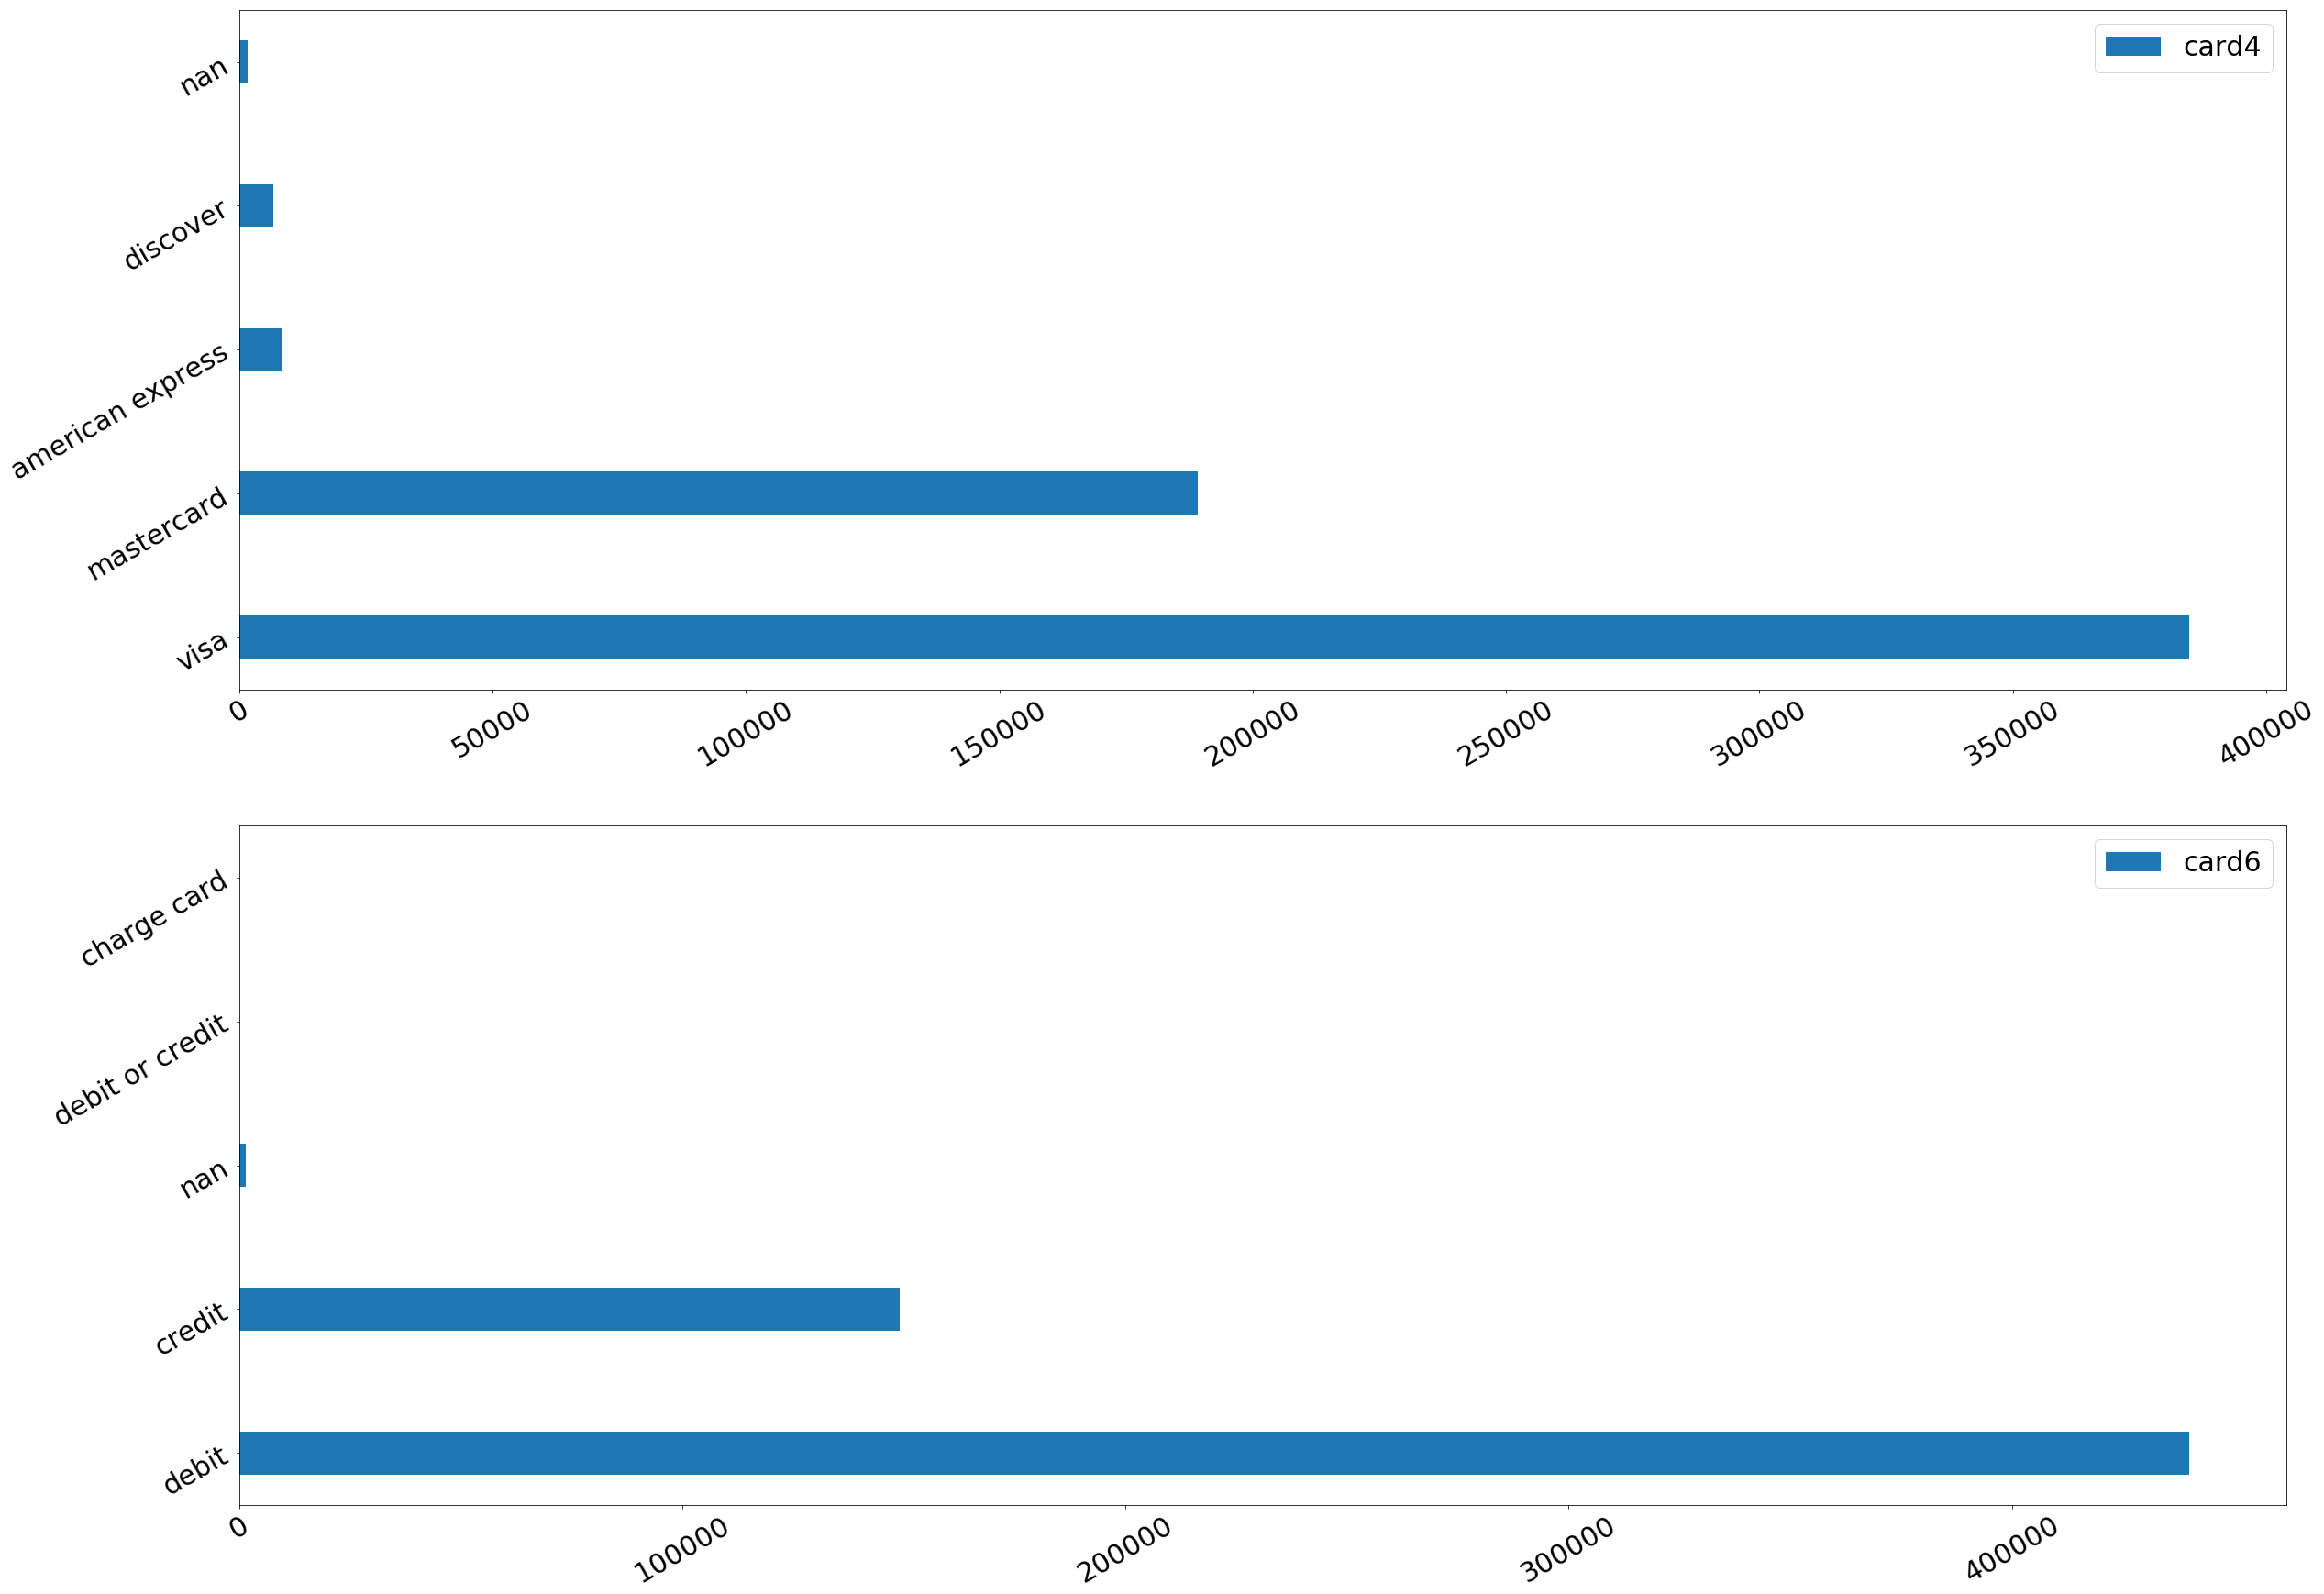

In [34]:
visualize_cols(df_train, ['card4', 'card6'], (2, 1))

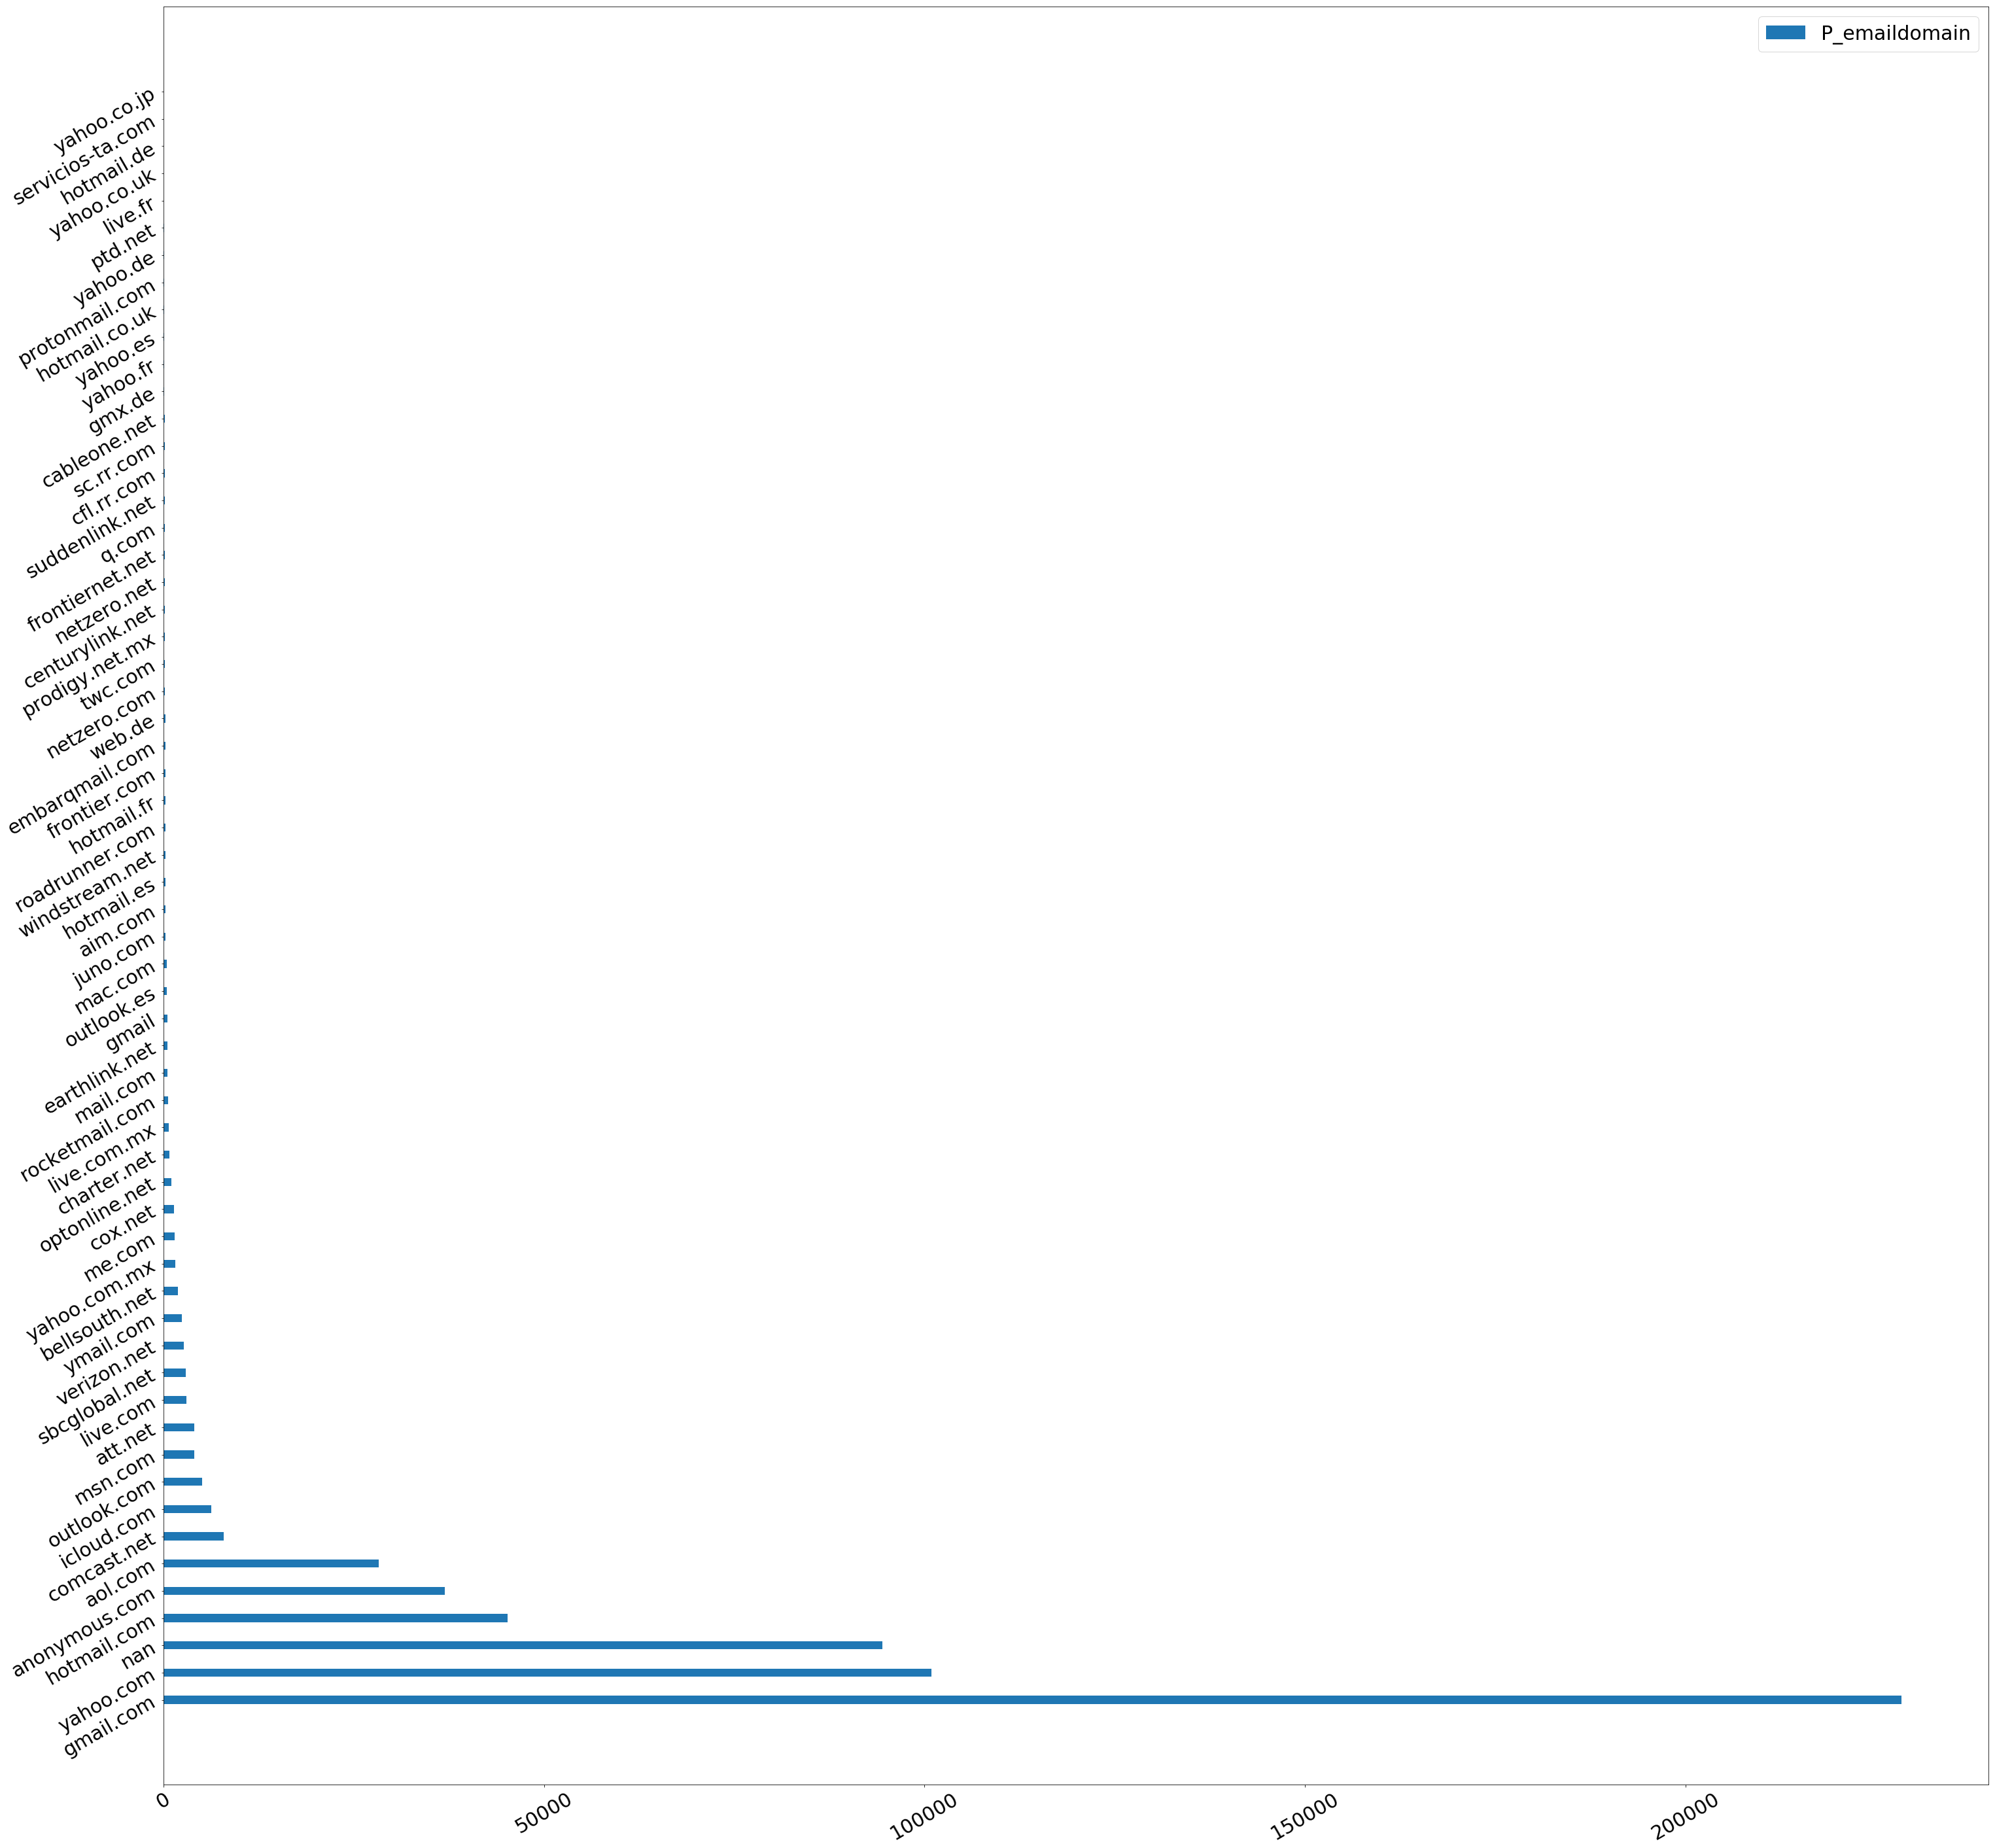

In [35]:
 visualize_cols(df_train, ['P_emaildomain'], figsize=(50, 50))

In [ ]:
df_train['M5'].value_counts(dropna=False)

In [26]:
gc.collect()

4813

In [183]:
'''
#. 重定义数值列的类型，可以压缩2/3
#. 空值太多，如何处理
#. 删去了空值占比大于0.75的特征
#. 数值nan = min(当天列)-1
#. 类别型空值直接赋一个other，网上看到可以用ffill和bfill
#. 类别特征dummy，但P_emaildomain特征的取值太多，是否还需要dummy，
    #占比低的是否可以重新划分成一类
'''

'''
#email 保留前几列，后面的和nan一起化一类
    #词向量
#C、D、V类特征按类降维
#编码器？

#DT datetime -> 分 早晚之类的
    #设置slice，统计区间内数量
#Amt 交易额
#identity

#离散特征dummy应该把train和test混在一起操作
'''


3

In [27]:
#应该还可以提高，不然others类别占比比正常值还高
use_top_email = 8

use_top_email_cols = (df_train['P_emaildomain'].value_counts(dropna=False) / \
                      df_train.shape[0] * 100)[:use_top_email]

print('top {0} email domain rank {1} %'.format(use_top_email, use_top_email_cols.sum()))

df_train['P_emaildomain'] = df_train['P_emaildomain'].apply(lambda x: \
                                                        x if x in use_top_email_cols.index else 'others')

df_test['P_emaildomain'] = df_test['P_emaildomain'].apply(lambda x: \
                                                        x if x in use_top_email_cols.index else 'others')

top 8 email domain rank 92.87042368002169 %


In [28]:
df_train['P_emaildomain'].value_counts(dropna=False)

gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
others            42103
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
Name: P_emaildomain, dtype: int64

In [29]:
#d1 = pd.get_dummies(df_train['M1'], dummy_na=True, prefix='M1_')
#except P_emaildomain
#部分列取值范围不一样，甚至test取值比train取值更广，是以train的为准，还是全集为准
def fill_dummy_category(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    print("before, data shape {0}".format(props.shape))
    need_drop = []
    need_add = pd.DataFrame()
    for col in props.columns:
        if props[col].dtype == object:  # Exclude strings
            
            need_drop.append(col)
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            print("取值种类: {0}".format(len(props[col].value_counts(dropna=False).index)))
            
            dummy = pd.get_dummies(props[col], dummy_na=True, prefix='%s_'%col)
            
            need_add = pd.concat((need_add, dummy), axis=1)


    props = props.drop(need_drop, axis=1)
    props = pd.concat((props, need_add), axis=1)
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    print("after, data shape {0}".format(props.shape))
    return props

#df_train_dy = fill_dummy_category(df_train)
#df_test_dy = fill_dummy_category(df_test)
df_all_dy = fill_dummy_category(pd.concat((df_train, df_test), axis=0).reset_index())

Memory usage of properties dataframe is : 619.469482421875  MB
before, data shape (1097231, 227)
******************************
Column:  M1
取值种类: 3
******************************
Column:  M2
取值种类: 3
******************************
Column:  M3
取值种类: 3
******************************
Column:  M4
取值种类: 4
******************************
Column:  M5
取值种类: 3
******************************
Column:  M6
取值种类: 3
******************************
Column:  M7
取值种类: 3
******************************
Column:  M8
取值种类: 3
******************************
Column:  M9
取值种类: 3
******************************
Column:  P_emaildomain
取值种类: 9
******************************
Column:  ProductCD
取值种类: 5
******************************
Column:  card4
取值种类: 5
******************************
Column:  card6
取值种类: 5
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  566.103030204773  MB
This is  91.38513619614305 % of the initial size
after, data shape (1097231, 267)


In [30]:
with open("train_test_590540.pkl", 'wb') as f:
    pickle.dump(df_all_dy, f)

In [33]:
df_train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,99.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#tmp = pd.concat((df_train, df_test), axis=0).reset_index()
df_all_dy.info()

df_all_dy.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Columns: 267 entries, index to card6__nan
dtypes: float16(187), float32(22), float64(1), int16(1), int32(2), int64(1), uint8(53)
memory usage: 566.1 MB


index                           0
C1                              0
C10                             0
C11                             0
C12                             0
C13                             0
C14                             0
C2                              0
C3                              0
C4                              0
C5                              0
C6                              0
C7                              0
C8                              0
C9                              0
D1                              0
D10                             0
D11                             0
D15                             0
D2                              0
D3                              0
D4                              0
D5                              0
TransactionAmt                  0
TransactionDT                   0
TransactionID                   0
V1                              0
V10                             0
V100                            0
V101          

In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 225 entries, TransactionID to V321
dtypes: float16(187), float32(22), int16(1), int32(2), object(13)
memory usage: 302.2+ MB


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 226 entries, TransactionID to V321
dtypes: float16(191), float32(18), int16(1), int32(2), int8(1), object(13)
memory usage: 325.0+ MB


In [312]:
list(filter(lambda x:x[:13] == 'P_emaildomain', df_train.columns))

['P_emaildomain',
 'P_emaildomain__anonymous.com',
 'P_emaildomain__aol.com',
 'P_emaildomain__comcast.net',
 'P_emaildomain__gmail.com',
 'P_emaildomain__hotmail.com',
 'P_emaildomain__icloud.com',
 'P_emaildomain__others',
 'P_emaildomain__yahoo.com',
 'P_emaildomain__nan']

In [42]:
tmp = df_all_dy.isnull().sum() 

In [46]:
for col in tmp.index:
    if tmp[col] > 0:
        print(col)

isFraud


In [45]:
tmp.index

Index(['index', 'C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4',
       ...
       'card4__american express', 'card4__discover', 'card4__mastercard',
       'card4__visa', 'card4__nan', 'card6__charge card', 'card6__credit',
       'card6__debit', 'card6__debit or credit', 'card6__nan'],
      dtype='object', length=267)

In [47]:
df_all_dy.isnull().sum().sum()

506691